In [106]:
# Autoregressive model: Y(t) = a * Y(t-1) + e
# a = parameter, estimate from data
# e = white noise, mean(e) = 0, std(e) = value

# ARIMA
# Y(t) = m + r1 * Y(t-1) + r2 * Y(t-2) + ... + rn * Y(t-n) +
#        w1 * e(t-1) + w2 * e(t-2) + ... + wm * e(t-m) + e(t)
# r1, r2, ..., rn and w1, w2, ..., wm are parameters which I estimate from the data

In [107]:
# OBJECTIVE: Build an ARIMA model to forecast TESLA stock price 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import statsmodels.api as sm 

In [108]:
import warnings
warnings.filterwarnings("ignore")

In [109]:
# Load the data 
import yfinance as yf 

START_DATE = "2019-01-08"
END_DATE = "2023-12-12"
TICKER = "TSLA"

price = yf.download(TICKER, start=START_DATE, end=END_DATE, interval="1mo")
price.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-02-01,20.361334,21.615999,19.251333,21.325333,21.325333,1928251500
2019-03-01,20.462667,20.475332,16.964001,18.657333,18.657333,3206902500
2019-04-01,18.841333,19.744667,15.408667,15.912667,15.912667,3461209500
2019-05-01,15.923333,17.223333,12.273333,12.344000,12.344000,4238982000
2019-06-01,12.367333,15.649333,11.799333,14.897333,14.897333,3224559000


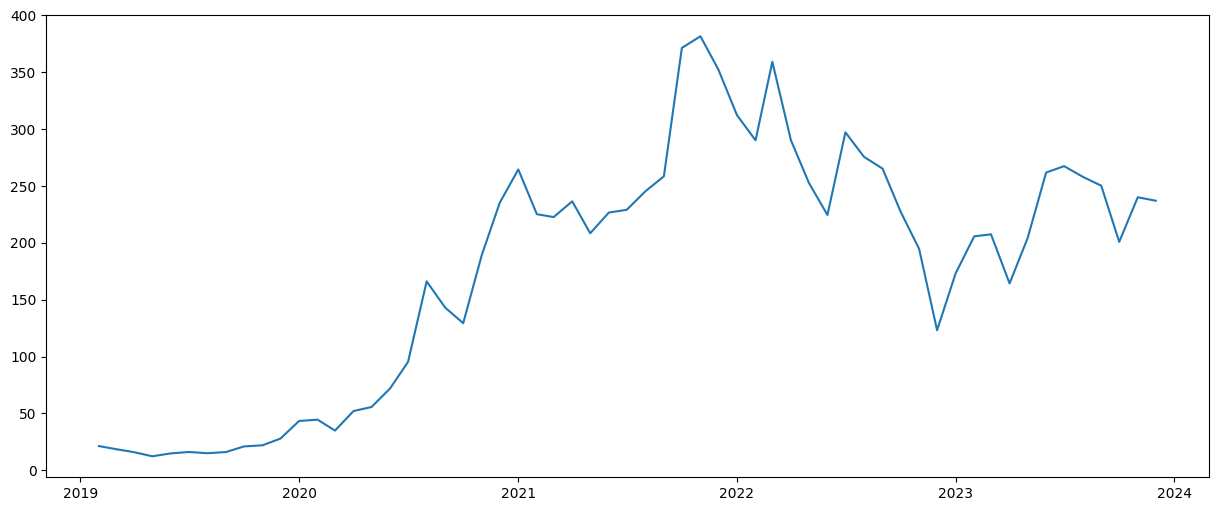

,Close
Date,
2019-02-01,21.325333
2019-03-01,18.657333
2019-04-01,15.912667
2019-05-01,12.344000
2019-06-01,14.897333


In [135]:
price["Date"] = price.index
close = price[["Date", "Close"]]
close.dropna(inplace=True)

_ = plt.figure(figsize=(15, 6))
plt.plot(close["Date"], close["Close"])
plt.show()

close.set_index(close["Date"], inplace=True)
close.asfreq("M")
close.drop("Date", axis=1, inplace=True)

close.head()

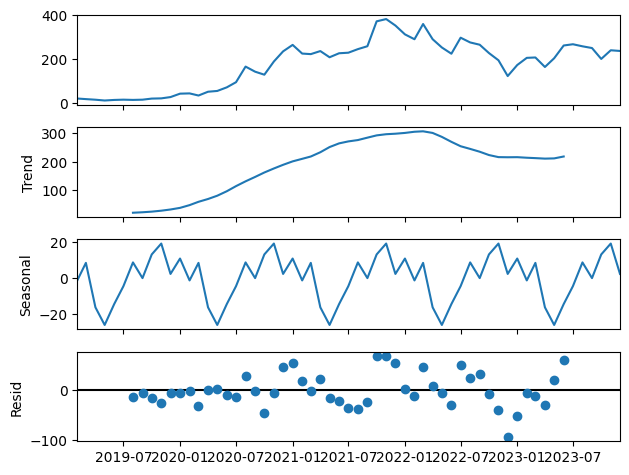

In [111]:
decomposition = sm.tsa.seasonal_decompose(close)
fig = decomposition.plot()
plt.show()

In [112]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [113]:
seasonl_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonl_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [116]:
for param in pdq:
    for param_seasonal in seasonl_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(close, 
                                              order=param, 
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
            results = model.fit(disp=False)
            print(f"ARIMA{param}x{param_seasonal}: AIC = {results.aic}")
        except Exception as e: 
            # print(f"--ERROR: {e}")
            continue

# AIC = Akaike Information Criterion

ARIMA(0, 0, 0)x(0, 0, 0, 12): AIC = 786.6498168020652
ARIMA(0, 0, 0)x(0, 0, 1, 12): AIC = 606.1218846568773
ARIMA(0, 0, 0)x(0, 1, 0, 12): AIC = 576.1378553097837
ARIMA(0, 0, 0)x(0, 1, 1, 12): AIC = 1480.6277036758938
ARIMA(0, 0, 0)x(1, 0, 0, 12): AIC = 589.5440121017156
ARIMA(0, 0, 0)x(1, 0, 1, 12): AIC = 578.4531823409374
ARIMA(0, 0, 0)x(1, 1, 0, 12): AIC = 439.6289708405785
ARIMA(0, 0, 0)x(1, 1, 1, 12): AIC = 427.69912468600126
ARIMA(0, 0, 1)x(0, 0, 0, 12): AIC = 712.1114385870239
ARIMA(0, 0, 1)x(0, 0, 1, 12): AIC = 551.7463729983373
ARIMA(0, 0, 1)x(0, 1, 0, 12): AIC = 528.1775818589604
ARIMA(0, 0, 1)x(0, 1, 1, 12): AIC = 1404.6177794533105
ARIMA(0, 0, 1)x(1, 0, 0, 12): AIC = 551.6594570735734
ARIMA(0, 0, 1)x(1, 0, 1, 12): AIC = 532.2948067640733
ARIMA(0, 0, 1)x(1, 1, 0, 12): AIC = 413.09057312768005
ARIMA(0, 0, 1)x(1, 1, 1, 12): AIC = 383.2849078890516
ARIMA(0, 1, 0)x(0, 0, 0, 12): AIC = 571.3111394133464
ARIMA(0, 1, 0)x(0, 0, 1, 12): AIC = 463.2144679089975
ARIMA(0, 1, 0)x(0, 1, 0,

In [118]:
# Choose model params with smallest AIC: ARIMA(1, 0, 1)x(1, 1, 1, 12)
model = sm.tsa.statespace.SARIMAX(close,
                                  order=(1, 0, 1),
                                  seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8991      0.087     10.307      0.000       0.728       1.070
ma.L1          0.0802      0.229      0.351      0.726      -0.368       0.528
ar.S.L12      -0.0022      0.242     -0.009      0.993      -0.476       0.471
ma.S.L12      -1.0000      0.298     -3.353      0.001      -1.585      -0.415
sigma2      1565.3974      0.000   8.22e+06      0.000    1565.397    1565.398


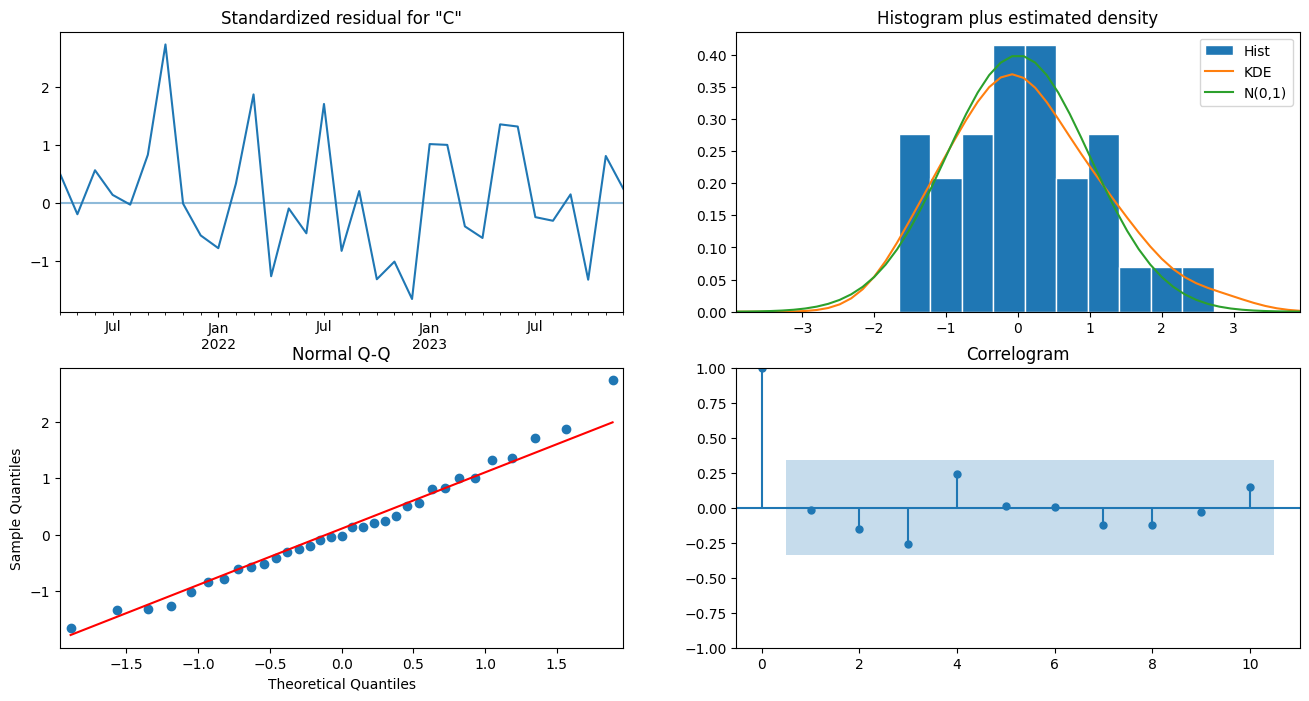

In [120]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

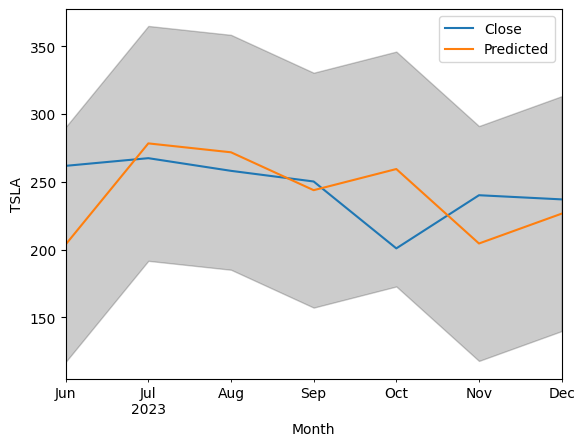

In [139]:
predictions = results.get_prediction(start=pd.to_datetime("2023-06-01"))
predictions_ci = predictions.conf_int()

ax = close[-7:].plot(label="Actual")
predictions.predicted_mean.plot(label="Predicted")

ax.fill_between(predictions_ci.index, 
                predictions_ci.iloc[:, 0], 
                predictions_ci.iloc[:, 1], 
                color='k', 
                alpha=0.2)
ax.set_xlabel("Month")
ax.set_ylabel("TSLA")
plt.legend()
plt.show()

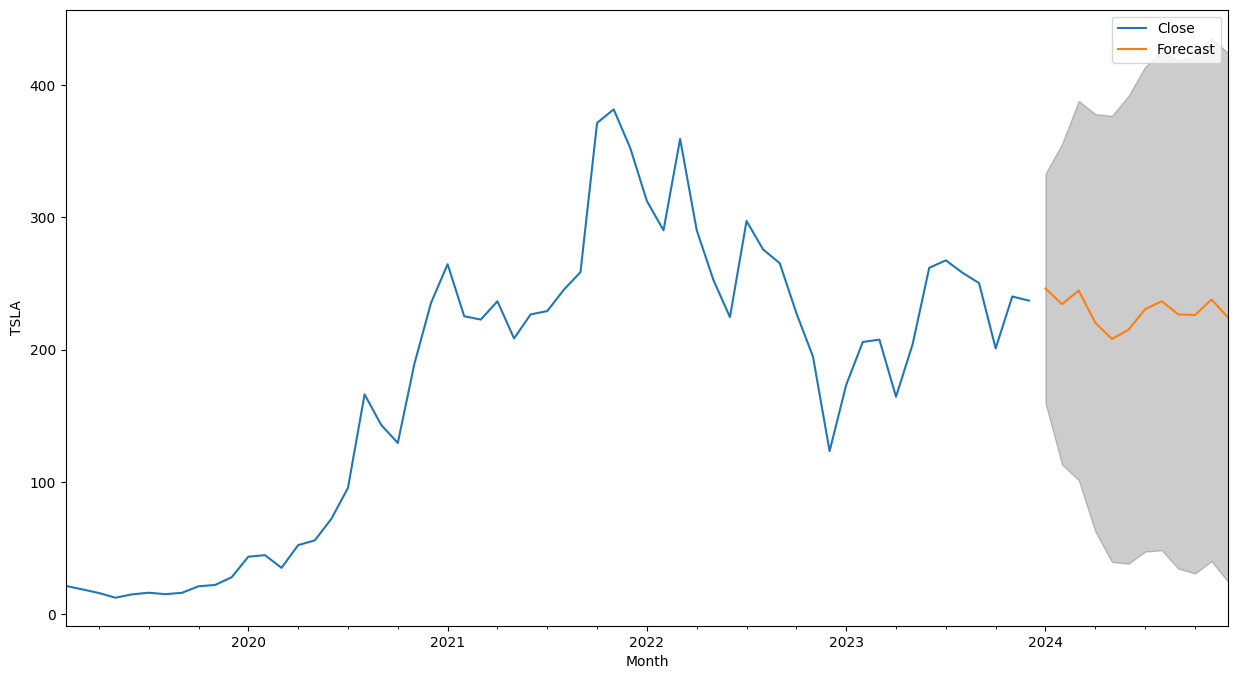

In [137]:
forecast = results.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

ax = close.plot(label="Real", figsize=(15, 8))
forecast.predicted_mean.plot(ax=ax, label="Forecast")
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0], 
                forecast_ci.iloc[:, 1],
                color='k',
                alpha=0.2)
ax.set_xlabel("Month")
ax.set_ylabel("TSLA")

plt.legend()
plt.show()

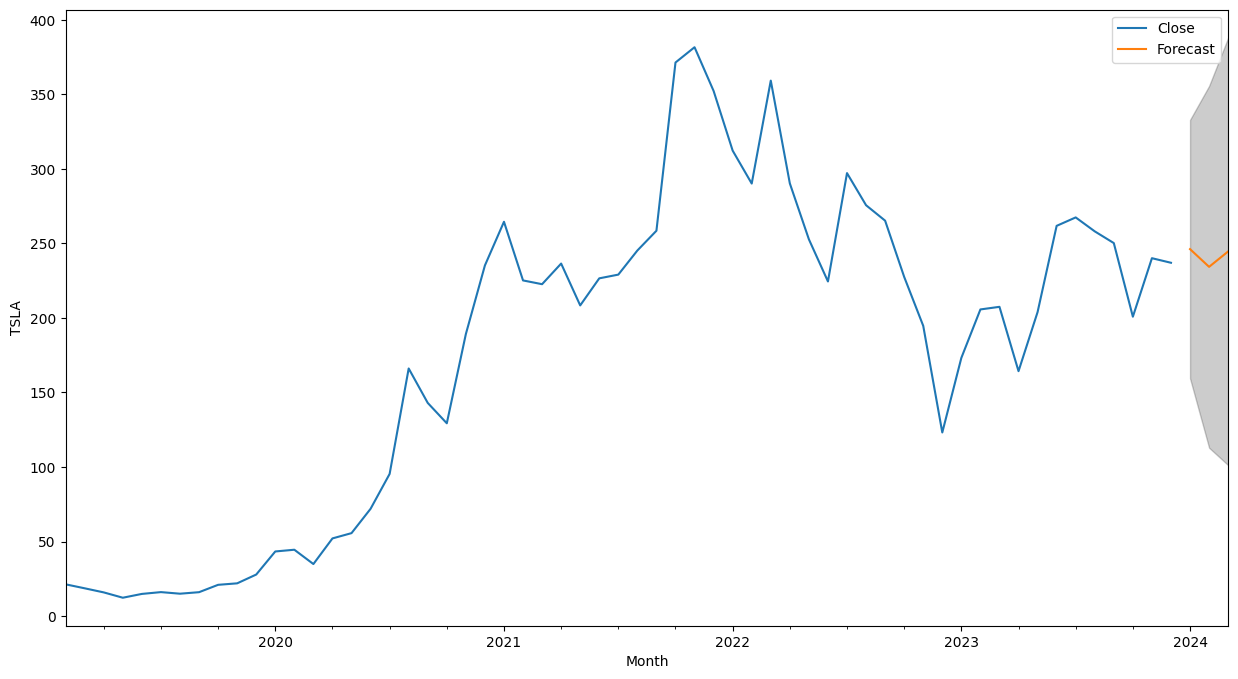

In [142]:
forecast = results.get_forecast(steps=3)
forecast_ci = forecast.conf_int()

ax = close.plot(label="Real", figsize=(15, 8))
forecast.predicted_mean.plot(ax=ax, label="Forecast")
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0], 
                forecast_ci.iloc[:, 1],
                color='k',
                alpha=0.2)
ax.set_xlabel("Month")
ax.set_ylabel("TSLA")

plt.legend()
plt.show()